In [ ]:
import os
import numpy as np
from tqdm import tqdm


DATA_FOLDER = "/Users/jackcollard/Downloads/GC_Matrices"

X = []
y = []
subjects = []


# determine label from filename
def get_label(filename):
    if filename.startswith("MDD"):
        return 1
    elif filename.startswith("H_") or filename.startswith("H_H"):
        return 0
    else:
        raise ValueError(f"Unrecognized filename pattern: {filename}")



# extract subject ID 
def get_subject_id(filename):

    parts = filename.split()

    # extract group
    if filename.startswith("MDD"):
        group = "MDD"
    else:
        group = "H"

    # find the S## pattern
    for p in parts:
        if p.startswith("S") and p[1:].isdigit():
            s_number = p   # e.g., "S15"
            return f"{group}_{s_number}"

    raise ValueError(f"Could not find subject ID in: {filename}")


#Find all matrices
files = [f for f in os.listdir(DATA_FOLDER) if f.endswith(".npy")]
print(f"Found {len(files)} matrix files.\n")



#Loop through files → load matrix, label, subject ID 
for f in tqdm(files, desc="Loading matrices"):
    full_path = os.path.join(DATA_FOLDER, f)

    # matrix 
    mat = np.load(full_path)
    X.append(mat)

    #  0 (Healthy) or 1 (MDD)
    y.append(get_label(f))

    # subject number
    subjects.append(get_subject_id(f))



# Convert to NumPy arrays
X = np.array(X)          # shape: (N, 19, 19)
y = np.array(y)          # shape: (N,)
subjects = np.array(subjects)

print("\nFinal array shapes:")
print("X:", X.shape)
print("y:", y.shape)
print("subjects:", subjects.shape)


# Save arrays as .npy files
np.save("X.npy", X)
np.save("y.npy", y)
np.save("subjects.npy", subjects)

print("\nSaved: X.npy, y.npy, subjects.npy ✔️")


Found 35877 matrix files.



Loading matrices: 100%|██████████| 35877/35877 [00:04<00:00, 7403.84it/s]



Final array shapes:
X: (35877, 19, 19)
y: (35877,)
subjects: (35877,)

Saved: X.npy, y.npy, subjects.npy ✔️


In [ ]:

X = np.load("X.npy")
y = np.load("y.npy")
subjects = np.load("subjects.npy")


In [3]:
unique_subjects = np.unique(subjects)
print("Total subjects:", len(unique_subjects))
print(unique_subjects)



Total subjects: 63
['H_S1' 'H_S10' 'H_S11' 'H_S12' 'H_S13' 'H_S14' 'H_S15' 'H_S16' 'H_S17'
 'H_S18' 'H_S19' 'H_S2' 'H_S20' 'H_S21' 'H_S22' 'H_S23' 'H_S24' 'H_S25'
 'H_S26' 'H_S27' 'H_S28' 'H_S29' 'H_S3' 'H_S30' 'H_S4' 'H_S5' 'H_S6'
 'H_S7' 'H_S8' 'H_S9' 'MDD_S1' 'MDD_S10' 'MDD_S11' 'MDD_S12' 'MDD_S13'
 'MDD_S14' 'MDD_S15' 'MDD_S16' 'MDD_S17' 'MDD_S18' 'MDD_S19' 'MDD_S2'
 'MDD_S20' 'MDD_S21' 'MDD_S22' 'MDD_S23' 'MDD_S24' 'MDD_S25' 'MDD_S26'
 'MDD_S27' 'MDD_S28' 'MDD_S29' 'MDD_S3' 'MDD_S30' 'MDD_S31' 'MDD_S32'
 'MDD_S33' 'MDD_S34' 'MDD_S4' 'MDD_S5' 'MDD_S6' 'MDD_S7' 'MDD_S9']


In [29]:
from sklearn.model_selection import train_test_split

unique_subjects = np.unique(subjects)
n_subj = len(unique_subjects)
print("Number of subjects:", n_subj)

# Train (70%) and temp (30%)
train_subj, temp_subj = train_test_split(
    unique_subjects,
    test_size=0.30,
    random_state=42
)

# Val (15%) and Test (15%)
val_subj, test_subj = train_test_split(
    temp_subj,
    test_size=0.50,
    random_state=42
)

# print("Train subjects:", train_subj)
# print("Val subjects:", val_subj)
# print("Test subjects:", test_subj)


Number of subjects: 63


In [5]:
train_mask = np.isin(subjects, train_subj)
val_mask   = np.isin(subjects, val_subj)
test_mask  = np.isin(subjects, test_subj)

X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]



In [6]:
X_train = X_train.astype("float32") / X_train.max()
X_val   = X_val.astype("float32")   / X_val.max()
X_test  = X_test.astype("float32")  / X_test.max()


In [7]:
X_train = X_train.reshape(-1, 19, 19, 1)
X_val   = X_val.reshape(-1, 19, 19, 1)
X_test  = X_test.reshape(-1, 19, 19, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # 2D convolution to learn patterns in the 19x19 Granger matrices
    Conv2D(32, (3, 3), activation='relu', input_shape=(19, 19, 1)),
    MaxPooling2D((2, 2)),

    # Flatten into a vector
    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer: probability of MDD
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/Users/jackcollard/miniforge3/envs/tamar_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,721 (1.00 MB)

 Trainable params: 262,721 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9591 - loss: 0.1070 - val_accuracy: 0.5694 - val_loss: 1.9061
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9627 - loss: 0.0990 - val_accuracy: 0.5614 - val_loss: 2.0581
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9659 - loss: 0.0935 - val_accuracy: 0.5635 - val_loss: 1.9100
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9672 - loss: 0.0878 - val_accuracy: 0.5536 - val_loss: 2.3683


In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.6747 - loss: 2.0887
Test accuracy: 0.674693763256073


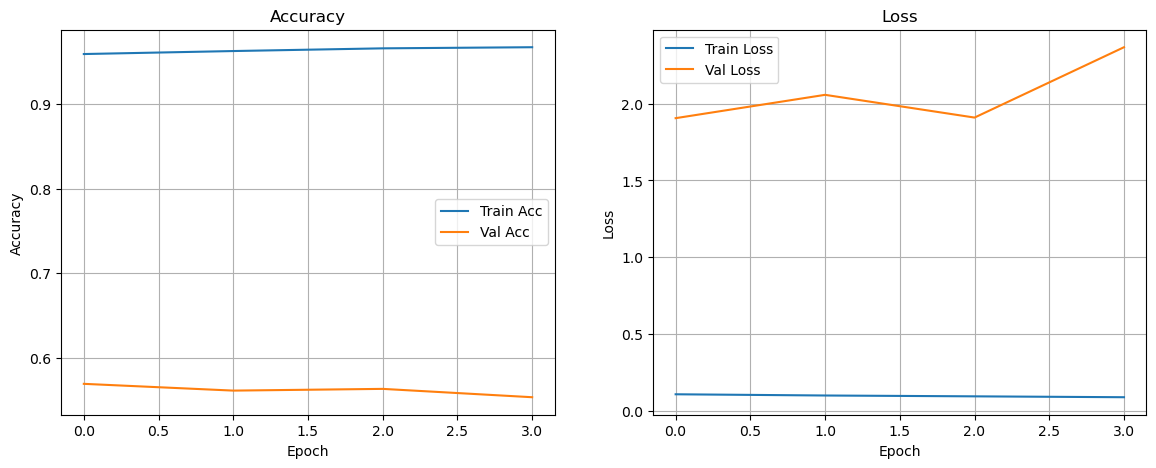

In [26]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(14,5))

# Accuracy subplot
axs[0].plot(history.history['accuracy'], label='Train Acc')
axs[0].plot(history.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss subplot
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.show()


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


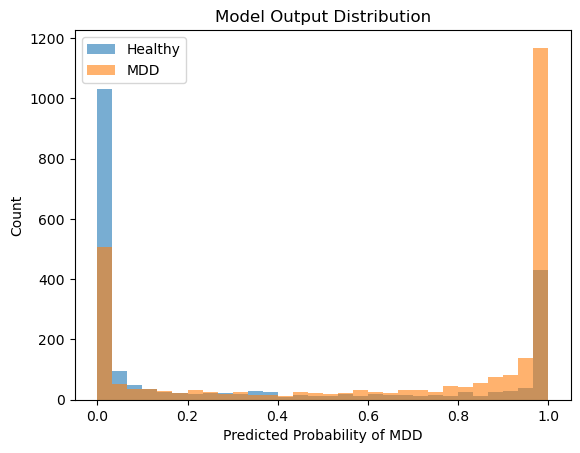

In [27]:
y_pred_prob = model.predict(X_test).flatten()

plt.hist(y_pred_prob[y_test==0], bins=30, alpha=0.6, label='Healthy')
plt.hist(y_pred_prob[y_test==1], bins=30, alpha=0.6, label='MDD')
plt.xlabel("Predicted Probability of MDD")
plt.ylabel("Count")
plt.title("Model Output Distribution")
plt.legend()
plt.show()


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step


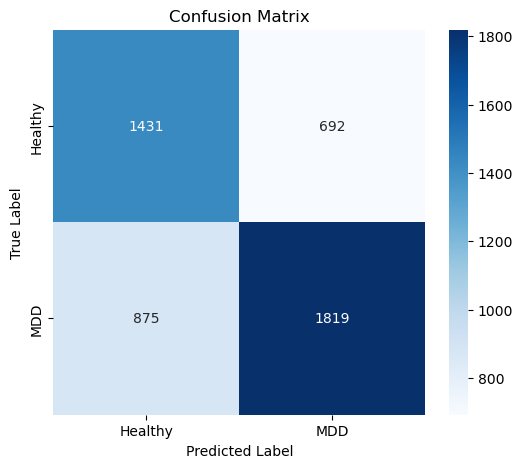

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted labels (threshold at 0.5)
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'MDD'],
            yticklabels=['Healthy', 'MDD'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()